In [1]:
from random import randint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modcods.util.modulation as md
import modcods.util.maee as maee

In [2]:
modcod_df = pd.read_excel('modcods_dvbs2.xlsx', index_col='acm')

print(modcod_df)

    order_name  order   rate                label         label_string  isend  \
acm                                                                             
0         QPSK      2   1/4      DVB-S2 QPSK 1/4      DVB_S2_QPSK_1r4   -2.35   
1         QPSK      2   1/3      DVB-S2 QPSK 1/3      DVB_S2_QPSK_1r3   -1.24   
2         QPSK      2   2/5      DVB-S2 QPSK 2/5      DVB_S2_QPSK_2r5   -0.30   
3         QPSK      2   1/2      DVB-S2 QPSK 1/2      DVB_S2_QPSK_1r2    1.00   
4         QPSK      2   3/5      DVB-S2 QPSK 3/5      DVB_S2_QPSK_3r5    2.23   
5         QPSK      2   2/3      DVB-S2 QPSK 2/3      DVB_S2_QPSK_2r3    3.10   
6         QPSK      2   3/4      DVB-S2 QPSK 3/4      DVB_S2_QPSK_3r4    4.03   
7         QPSK      2   4/5      DVB-S2 QPSK 4/5      DVB_S2_QPSK_4r5    4.68   
8         QPSK      2   5/6      DVB-S2 QPSK 5/6      DVB_S2_QPSK_5r6    5.18   
9         QPSK      2   8/9      DVB-S2 QPSK 8/9      DVB_S2_QPSK_8r9    6.20   
10        QPSK      2  9/10 

In [3]:
upsample = 10

t, h_rrc = md.raised_root_cosine(upsample, 3, 0.35)

# fig, ax = plt.subplots(figsize=(8,8))
# ax.plot(t, h_rrc)

In [4]:
VkVs_list = [0.0, 0.12, 0.31, 0.43]

# Calculate maee for each VkVs
for VkVs in VkVs_list:

    a, Pdiss, gamma = maee.power_dissipation_profile(VkVs)

    if False:
        maee.plot_disspation_profile(a, Pdiss, gamma)

    max_mod_order = np.max(modcod_df['order'])
    N_sym = 100 * max_mod_order
    N_bit = N_sym * 2**max_mod_order

    bit_seq = np.random.randint(0, 2, N_bit)

    eta_maee = np.zeros(len(modcod_df))
    papr = np.zeros(len(modcod_df))
    EPD = np.zeros(len(modcod_df))

    mag_list = [None] * len(modcod_df)
    filt_sym_seq_list = [None] * len(modcod_df)

    # Generate symbols
    for i, row in modcod_df.iterrows():

        symbols, grey_mapping = md.generate_apsk_symbols(row)
        mod_order = int(np.log2(len(symbols)))

        seq_len = int((N_sym / 5) * mod_order * (2**mod_order))
        sym_seq = md.modulate(symbols, grey_mapping, bit_seq[:seq_len])
        filt_sym_seq = np.convolve(sym_seq.repeat(upsample), h_rrc)
        filt_sym_seq = filt_sym_seq / np.max(np.abs(filt_sym_seq))

        filt_sym_seq_list[i] = filt_sym_seq

    # Calculate metrics
    for i, row in modcod_df.iterrows():

        filt_sym_seq = filt_sym_seq_list[i]

        # PAPR
        papr[i] = maee.papr(filt_sym_seq)

        # MAEE
        eta_maee[i] = maee.maee(filt_sym_seq, a, Pdiss)

    modcod_df['maee_%d' % int(VkVs * 100)] = eta_maee
    modcod_df['papr'] = papr

In [5]:
modcod_df.to_pickle('dvbs2.pkl')

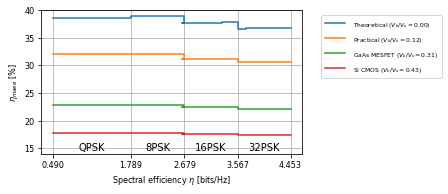

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6.4, 2.4))
#modcod_df = modcod_df.sort_values('eta')

maee_label = ["Theoretical ($V_k/V_s=%.2f$)" % VkVs_list[0],
              "Practical ($V_k/V_s=%.2f$)" % VkVs_list[1],
              "GaAs MESFET ($V_k/V_s=%.2f$)" % VkVs_list[2],
              "Si CMOS ($V_k/V_s=%.2f$)" % VkVs_list[3]]

for i, VkVs in enumerate(VkVs_list):
    ax.step(modcod_df.eta, modcod_df['maee_%d' % int(VkVs*100)] * 100, label=maee_label[i])

# ax.text(modcod_df.eta[0], modcod_df.maee[0] * 100 + .05, 'QPSK')
# ax.text(modcod_df.eta[11], modcod_df.maee[11] * 100 + .05, '8PSK')
# ax.text(modcod_df.eta[17], modcod_df.maee[17] * 100 + .05, '16PSK')
# ax.text(modcod_df.eta[23], modcod_df.maee[23] * 100 + .05, '32PSK')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim((14, 40))

ax.text(modcod_df.eta[0] + np.diff(modcod_df.eta[[0,10]])/2, 14.5, 'QPSK', horizontalalignment='center',)
ax.text(modcod_df.eta[10] + np.diff(modcod_df.eta[[10,16]])/2, 14.5, '8PSK', horizontalalignment='center',)
ax.text(modcod_df.eta[16] + np.diff(modcod_df.eta[[16,22]])/2, 14.5, '16PSK', horizontalalignment='center',)
ax.text(modcod_df.eta[22] + np.diff(modcod_df.eta[[22,27]])/2, 14.5, '32PSK', horizontalalignment='center',)

#ax.plot(papr)
# for i, row in modcod_df.iterrows():
#     ax.text(row.eta, row.maee, row.order_name + row.rate)

#ax.set_ylim((22.8, 23.7))
ax.grid()
ax.set_ylabel('$\eta_{maee}$ [%]')
ax.set_xlabel('Spectral efficiency $\eta$ [bits/Hz]')
ax.set_xticks(modcod_df.loc[[0,10,16,22,27]].eta)

from pyreport import PlotUtil
PlotUtil.apply_report_formatting(6.4, 2.8)
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/maee_dvb_s2.pdf')

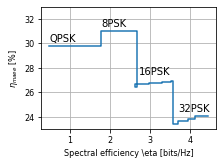

In [7]:
fig, ax = plt.subplots(1,1)
#modcod_df = modcod_df.sort_values('eta')

papr_db = 10*np.log10(modcod_df.papr)
#ax.step(modcod_df.eta, papr_db)
eta_papr = 0.5*10**(-papr_db/20)

ax.step(modcod_df.eta, eta_papr * 100)
ax.text(modcod_df.eta[0], eta_papr[0] * 100 + .4, 'QPSK')
ax.text(modcod_df.eta[11], eta_papr[11] * 100 + .4, '8PSK')
ax.text(modcod_df.eta[17] + 0.1, eta_papr[17] * 100 + 1, '16PSK')
ax.text(modcod_df.eta[23], eta_papr[23] * 100 + 1, '32PSK')

#ax.plot(papr)
# for i, row in modcod_df.iterrows():
#     ax.text(row.eta, row.maee, row.order_name + row.rate)

ax.set_ylim((23, 33))
ax.grid()
ax.set_ylabel('$\eta_{maee}$ [%]')
ax.set_xlabel('Spectral efficiency \eta [bits/Hz]')

from pyreport import PlotUtil
PlotUtil.apply_report_formatting()
plt.tight_layout()
plt.savefig('D:/git/thesis_report_ae/figures/papr_dvb_s2.pdf')

